In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

### Define beamline for loops

In [3]:
def define_devices(
    f1, f2, slit_width = 500e-6, alphaAsym = np.deg2rad(27.98), E0=E0, f0 = 290.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s')

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,
                              alphaAsym=alphaAsym, orientation=2,pol='s')
        
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2 + 1e-3, FOV=100e-6, N=256)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)
    
    # third crystal, asymmetric reflection, same orientation as crystal1
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z + f1, E0=E0,
                              alphaAsym=-alphaAsym, asym_type='emergence', orientation=2, pol='s')
    
    # viewing after crystal 3
    im1 = optics.PPM('after_c3', z=crystal3.z+.1,N=256,FOV=2e-3)

    # fourth crystal, symmetric reflection, same orientation as crystal2
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crystal3.z+.2, E0=E0,
                              alphaAsym=0, asym_type='emergence', orientation=0, pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2, crl1, slit, focus, crl2, crystal3, im1, crystal4, im2]

    return devices

In [4]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.750953177257525
f2 = 10.

devices = define_devices(f1, f2)

# initialize beamline
mono_beamline = beamline.Beamline(devices)
# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)
pulse.propagate(beamline=mono_beamline, screen_names=['im0', 'focus','after_c3','im2'])
tfin = time.time()

each run: 32.25s, per slice: 143.99ms
total 32.25s, per slice 143.99ms


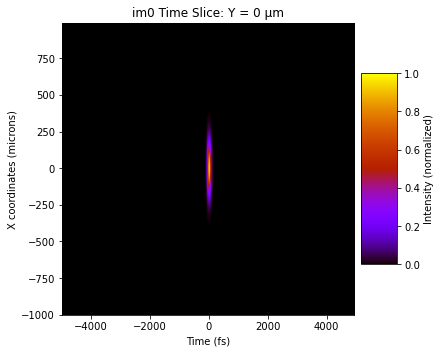

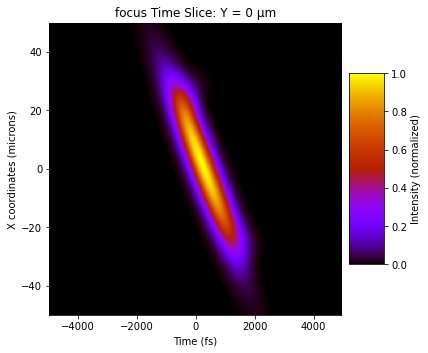

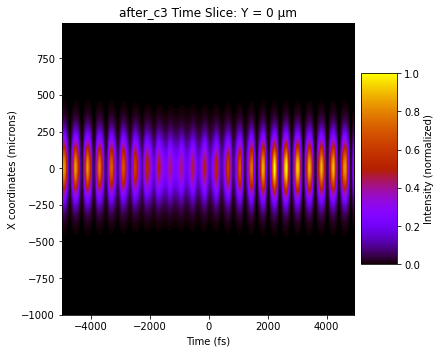

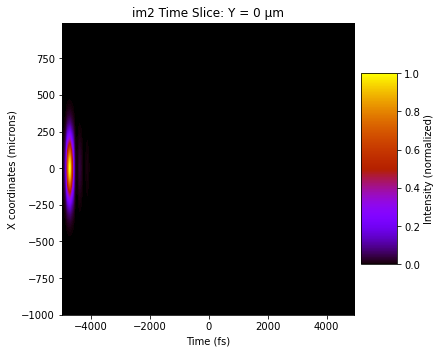

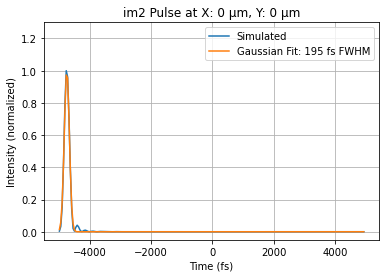

In [5]:
print('each run: {}s, per slice: {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))
''' energy slices '''

''' time slice '''
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
pulse.imshow_time_slice('im0', shift = shift)
pulse.imshow_time_slice('focus',shift= shift)
pulse.imshow_time_slice('after_c3', shift = shift)
pulse.imshow_time_slice('im2', shift = shift)
pulse.plot_pulse('im2', shift = shift)


### Loops

In [6]:
%%capture capt
tstart = time.time()
NN = 150
f0_list = 290.0 + np.linspace(-10, 10, NN)

fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots_flip34/"

hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'collimation_tolerance_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000., 4))

# initialize results holder
duration = np.zeros(NN)
tilt = np.zeros(NN)
bw = np.zeros(NN)
throughput = np.zeros(NN)
cent_E = np.zeros(NN)
slit_width = 100e-6
# pulse duration and tilt (open slit)
for i, f0 in enumerate(f0_list):
    devices = define_devices(f1, f2, slit_width, f0=f0)
    mono_beamline = beamline.Beamline(devices)    # initialize beamline
    beam_params['photonEnergy'] = E0    # reset central photon energy

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)

    print('Number of spectral components: {:d}'.format(pulse.N))
    pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
    centroid, duration[i] = pulse.pulse_duration('im2')
    tilt[i] = pulse.pulsefront_tilt('im2')
tfin = time.time()

slit_width = 7e-6
# else (closed slit)
for i, f0 in enumerate(f0_list):
    devices = define_devices(f1, f2, slit_width, f0=f0)
    mono_beamline = beamline.Beamline(devices)    # initialize beamline
    beam_params['photonEnergy'] = E0    # reset central photon energy

    # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
    pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=10000)

    print('Number of spectral components: {:d}'.format(pulse.N))
    pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
    bw[i] = pulse.pulse_bandwidth('im2')
    throughput[i] = pulse.throughput('im0','im2')
    cent_E[i] = pulse.central_energy('im2')
tfin = time.time()

for i in range(2):
    winsound.Beep(1000,1000)
    time.sleep(1.1)



In [7]:
print('time per slice {}ms'.format(1000*(tfin-tstart)/4/2/NN/pulse.N))
print('total time {}s'.format(tfin-tstart))

# save data
with h5py.File(fig_path+fname+'.h5','w') as f:
    f.create_dataset('f0', data=f0_list)
    f.create_dataset('duration', data=duration)
    f.create_dataset('tilt', data=tilt)
    f.create_dataset('bandwidth', data=bw)
    f.create_dataset('throughput', data=throughput)
    f.create_dataset('central_energy', data=cent_E)
 

time per slice 26.904563960574922ms
total time 7231.946792602539s


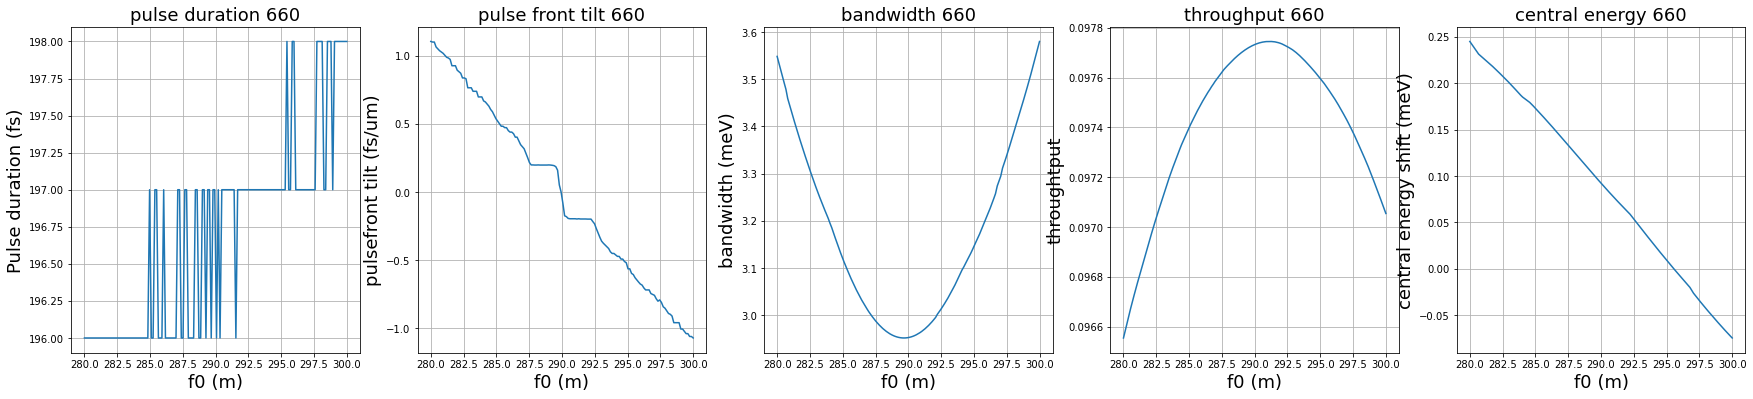

In [8]:
# plots
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots_flip34/"

hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'collimation_tolerance_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000., 4))

with h5py.File(fig_path+fname+'.h5','r') as f:
    f0_list = f['f0'][:]
    duration = f['duration'][:]
    tilt = f['tilt'][:]
    bw = f['bandwidth'][:]
    throughput = f['throughput'][:]
    cent_E = f['central_energy'][:]

xx = f0_list
xlabel = 'f0 (m)'

# pulse duration
plt.figure(figsize=(30,6))
plt.subplot(1,5,1)
plt.plot(xx, np.abs(duration))
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('Pulse duration (fs)',fontsize=(18))
#plt.yscale('log')
#plt.ylim((300,2000))

plt.grid()
plt.title('pulse duration {}'.format(hkl),fontsize=(18))

# pulsefront tilt
plt.subplot(1,5,2)
plt.plot(xx, tilt)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

plt.grid()
plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))

# bandwidth
plt.subplot(1,5,3)
plt.plot(xx, 1e3*bw)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('bandwidth (meV)',fontsize=(18))

plt.grid()
plt.title('bandwidth {}'.format(hkl),fontsize=(18))

# throughput
plt.subplot(1,5,4)
plt.plot(xx, throughput)
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('throughtput',fontsize=(18))

plt.grid()
plt.title('throughput {}'.format(hkl),fontsize=(18))

# central energy
plt.subplot(1,5,5)
plt.plot(xx, 1e3*(cent_E-E0))
plt.xlabel(xlabel,fontsize=(18))
plt.ylabel('central energy shift (meV)',fontsize=(18))

plt.grid()
plt.title('central energy {}'.format(hkl),fontsize=(18))

plt.savefig(fig_path+fname+'.png')